In [1]:
!pwd

/home/chen/dev/Digital-Twin-Fault-Diagnosis/scripts


In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import scipy.io
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

categories = [
    'Healthy',
    'Motor_1_Stuck',
    'Motor_1_Steady_state_error',
    'Motor_2_Stuck',
    'Motor_2_Steady_state_error',
    'Motor_3_Stuck',
    'Motor_3_Steady_state_error',
    'Motor_4_Stuck',
    'Motor_4_Steady_state_error'
]

# 定义一个函数来标准化特征
def normalize_features(X):
    mean = X.mean(dim=(0, 1), keepdim=True)  # 计算每个特征的均值
    std = X.std(dim=(0, 1), keepdim=True)  # 计算每个特征的标准差
    std[std == 0] = 1e-8  # 防止除以零
    X_normalized = (X - mean) / std  # 标准化
    return X_normalized

# 定义一个函数来计算模型的准确度
def print_confusion_matrix(y_test, predicted, categories):
    precision = precision_score(y_test.cpu(), predicted.cpu(), average='weighted')
    recall = recall_score(y_test.cpu(), predicted.cpu(), average='weighted')
    f1 = f1_score(y_test.cpu(), predicted.cpu(), average='weighted')
    print(f'Overall Test Accuracy: {accuracy * 100:.2f}%')
    # 绘制混淆矩阵
    cm = confusion_matrix(y_test.cpu(), predicted.cpu())
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
  # 打印每个类别的精确度、召回率和 F1 分数
    for i, category in enumerate(categories):
        precision = precision_score(y_test.cpu(), predicted.cpu(), labels=[i], average='weighted')
        recall = recall_score(y_test.cpu(), predicted.cpu(), labels=[i], average='weighted')
        f1 = f1_score(y_test.cpu(), predicted.cpu(), labels=[i], average='weighted')
        
        print(f'Category: {category},Precision: {precision:.2f},Recall: {recall:.2f},F1 Score: {f1:.2f}')
      

     
# 定义一个函数来将 .mat 文件转换为 PyTorch 张量
def transfer_tensor(mat, X_name, Y_name, mean=None, std=None):
     # 提取嵌套数组
    data_X = mat[X_name][0]  # 提取出嵌套的 object 数组
    data_Y = mat[Y_name][0]
    # 提取X到Tensor
    data_X_combined = np.array([data_X[i] for i in range(len(data_X))])
    # print(data_X_combined[0])
    data_tensor_X = torch.tensor(data_X_combined, dtype=torch.float32).to(device)  # 移到 GPU
    # 创建一个新的张量来存储处理后的数据
    data_tensor_X_with_residual = data_tensor_X.clone()  # 克隆一份以保留原始数据
    # 计算残差并替换后3个特征
    residual = data_tensor_X[:, :, :3] - data_tensor_X[:, :, 3:6]  # 计算残差
    data_tensor_X_with_residual[:, :, 3:6] = residual  # 将残差替换到后3个特征
    data_tensor_X = data_tensor_X_with_residual
    # 特征归一化
    if mean is None or std is None:
        # 如果未提供均值和标准差，则计算
        mean = data_tensor_X.mean(dim=(0, 1), keepdim=True)
        std = data_tensor_X.std(dim=(0, 1), keepdim=True)
    data_tensor_X = (data_tensor_X - mean) / std  # 标准化
    # 提取Y到Tensor
    data_Y_combined = np.array([data_Y[i] for i in range(len(data_Y))])
    data_Y_combined = data_Y_combined.flatten()
    # 创建字典，将每个类别映射到对应的序号
    category_to_index = {category: index for index, category in enumerate(categories)}
    data_Y_numeric = np.array([category_to_index[category] for category in data_Y_combined])
    # 将 NumPy 数组转换为 PyTorch 张量
    data_tensor_Y = torch.tensor(data_Y_numeric, dtype=torch.int64).to(device)  # 移到 GPU
    return data_tensor_X, data_tensor_Y, mean, std  # 返回均值和标准差


# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# load from .mat file as dictionary
mat = scipy.io.loadmat('../mydataset/my_dataset_train.mat')
mat_test = scipy.io.loadmat('../mydataset/my_dataset_test.mat')
# transfer data to tensor
data_tensor_X, data_tensor_Y, simulation_mean, simulation_std = transfer_tensor(mat, 'X_array', 'y_array')
data_tensor_X_real, data_tensor_Y_real, temp_mean, temp_std = transfer_tensor(mat_test, 'X_test_array', 'y_test_array', mean=simulation_mean, std=simulation_std)

print("tensor X:", data_tensor_X.shape)
print("tensor Y:", data_tensor_Y.shape)
print("tensor X real:", data_tensor_X_real.shape)
print("tensor Y real:", data_tensor_Y_real.shape)


Using device: cuda
tensor X: torch.Size([3600, 1000, 6])
tensor Y: torch.Size([3600])
tensor X real: torch.Size([90, 1000, 6])
tensor Y real: torch.Size([90])


In [3]:

# 训练和验证集的创建
training_ratio = 0.9
n_dataset = data_tensor_X.shape[0]
training_size = int(training_ratio * n_dataset)

# 随机打乱索引
indices = np.arange(n_dataset)
np.random.shuffle(indices)

# 划分训练集和测试集
train_indices = indices[:training_size]
test_indices = indices[training_size:]

X_train = data_tensor_X[train_indices]
X_test = data_tensor_X[test_indices]
y_train = data_tensor_Y[train_indices]
y_test = data_tensor_Y[test_indices]

#划分真实数据测试集
X_test_real = data_tensor_X_real
y_test_real = data_tensor_Y_real


# 从 models.py 中导入模型
from models import *

# 模型参数设置
input_size = 6  # 根据数据特征维度
num_classes = len(categories)
print(num_classes)
# 初始化模型并移到 GPU
# model = LSTMModel(input_size = input_size, hidden_size = 100, num_classes = num_classes).to(device)
# model = CNNModel(input_size = input_size, num_classes=num_classes).to(device)
# model = ComplexCNN(input_size = input_size, num_classes=num_classes, num_channels=128).to(device)
# model = TransformerModel(input_size = input_size, hidden_size=32, num_classes=num_classes).to(device)
# model = TCN(input_size = input_size, output_size=num_classes, num_channels=[128,128,128]).to(device)
# model = MyTCN(input_size = input_size, num_classes=num_classes, num_channels=64).to(device)
model = CNNModelDANN(input_size = input_size, num_classes=num_classes).to(device)
# model = AlexNetDANN(input_size = input_size, num_classes=num_classes).to(device)

# 存储 loss,acc 值的列表
losses_train = []
losses_test = []
losses_test_real = []
losses_train_source = []
losses_train_target = []
acc_train = []
acc_test = []
acc_test_real = []
acc_train_source = []
acc_train_target = []


9


Epoch [1/250], lr: 0.001, alpha: 0.0000, Train Accuracy: 39.00%, Simu_val_Accuracy: 68.33%, REAL_ACCURACY: 64.44%  , Source Accuracy: 56.00%, Target Accuracy: 59.48%, Source Loss: 0.6784, Target Loss: 0.6750, Train_Loss: 1.5598, Simu_val_Loss: 0.9108, Real_Loss: 1.2691
Epoch [2/250], lr: 0.001, alpha: 0.0200, Train Accuracy: 75.18%, Simu_val_Accuracy: 80.56%, REAL_ACCURACY: 70.00%  , Source Accuracy: 56.77%, Target Accuracy: 71.70%, Source Loss: 0.6341, Target Loss: 0.6173, Train_Loss: 0.7394, Simu_val_Loss: 0.5371, Real_Loss: 1.7801
Epoch [3/250], lr: 0.001, alpha: 0.0400, Train Accuracy: 83.52%, Simu_val_Accuracy: 85.83%, REAL_ACCURACY: 68.89%  , Source Accuracy: 61.83%, Target Accuracy: 76.93%, Source Loss: 0.5731, Target Loss: 0.5445, Train_Loss: 0.4890, Simu_val_Loss: 0.4127, Real_Loss: 2.4575
Epoch [4/250], lr: 0.001, alpha: 0.0599, Train Accuracy: 85.75%, Simu_val_Accuracy: 87.50%, REAL_ACCURACY: 66.67%  , Source Accuracy: 66.64%, Target Accuracy: 77.96%, Source Loss: 0.5411, Ta

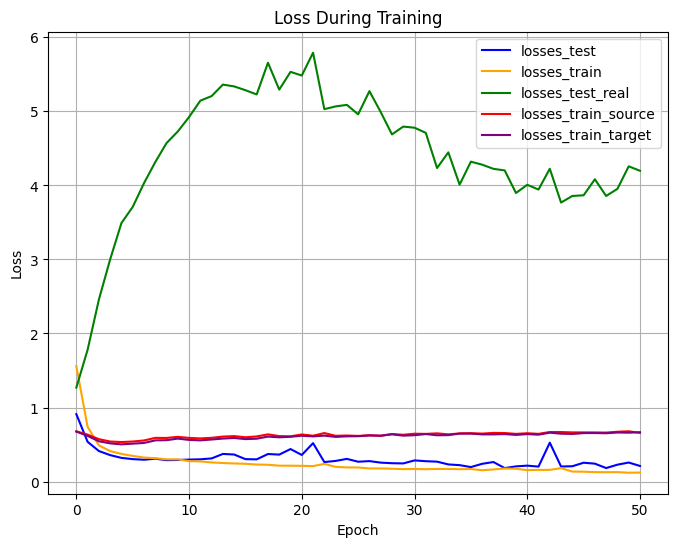

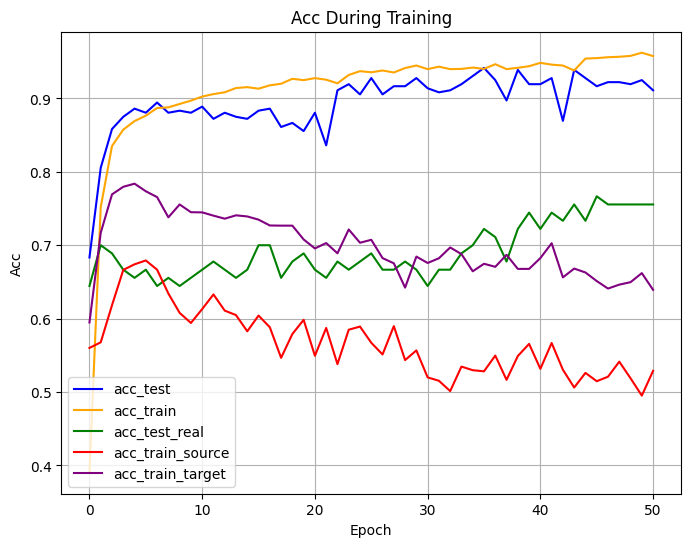

Epoch [51/250], lr: 0.001, alpha: 0.7616, Train Accuracy: 95.77%, Simu_val_Accuracy: 91.11%, REAL_ACCURACY: 75.56%  , Source Accuracy: 52.88%, Target Accuracy: 63.92%, Source Loss: 0.6579, Target Loss: 0.6667, Train_Loss: 0.1220, Simu_val_Loss: 0.2110, Real_Loss: 4.1977
Epoch [52/250], lr: 0.001, alpha: 0.7699, Train Accuracy: 95.74%, Simu_val_Accuracy: 92.78%, REAL_ACCURACY: 75.56%  , Source Accuracy: 50.25%, Target Accuracy: 64.63%, Source Loss: 0.6733, Target Loss: 0.6633, Train_Loss: 0.1247, Simu_val_Loss: 0.2109, Real_Loss: 4.1408
Epoch [53/250], lr: 0.001, alpha: 0.7779, Train Accuracy: 95.77%, Simu_val_Accuracy: 94.44%, REAL_ACCURACY: 76.67%  , Source Accuracy: 49.60%, Target Accuracy: 65.86%, Source Loss: 0.6784, Target Loss: 0.6708, Train_Loss: 0.1242, Simu_val_Loss: 0.2047, Real_Loss: 4.0096
Epoch [54/250], lr: 0.001, alpha: 0.7857, Train Accuracy: 96.69%, Simu_val_Accuracy: 93.33%, REAL_ACCURACY: 74.44%  , Source Accuracy: 50.15%, Target Accuracy: 63.27%, Source Loss: 0.6759

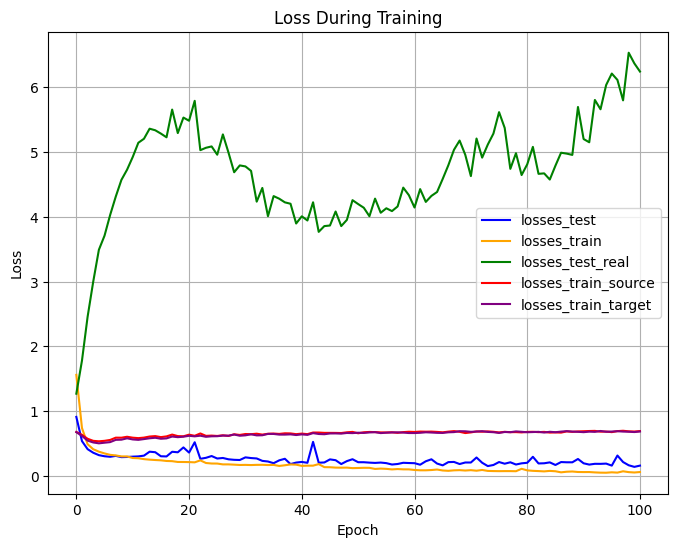

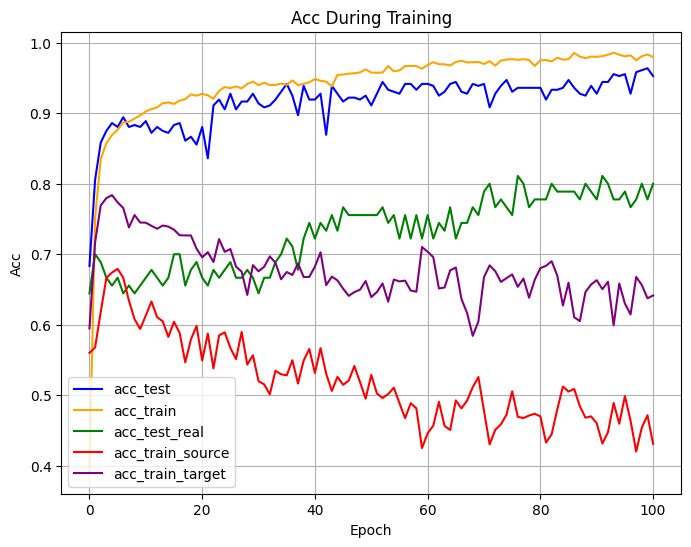

Epoch [101/250], lr: 0.001, alpha: 0.9640, Train Accuracy: 97.98%, Simu_val_Accuracy: 95.28%, REAL_ACCURACY: 80.00%  , Source Accuracy: 43.11%, Target Accuracy: 64.15%, Source Loss: 0.6919, Target Loss: 0.6854, Train_Loss: 0.0595, Simu_val_Loss: 0.1585, Real_Loss: 6.2439
Epoch [102/250], lr: 0.001, alpha: 0.9654, Train Accuracy: 98.19%, Simu_val_Accuracy: 96.67%, REAL_ACCURACY: 80.00%  , Source Accuracy: 41.54%, Target Accuracy: 66.60%, Source Loss: 0.6858, Target Loss: 0.6862, Train_Loss: 0.0513, Simu_val_Loss: 0.1463, Real_Loss: 5.7136
Epoch [103/250], lr: 0.001, alpha: 0.9667, Train Accuracy: 98.25%, Simu_val_Accuracy: 92.22%, REAL_ACCURACY: 78.89%  , Source Accuracy: 42.98%, Target Accuracy: 65.68%, Source Loss: 0.6868, Target Loss: 0.6829, Train_Loss: 0.0492, Simu_val_Loss: 0.3154, Real_Loss: 6.3952
Epoch [104/250], lr: 0.001, alpha: 0.9680, Train Accuracy: 97.86%, Simu_val_Accuracy: 96.11%, REAL_ACCURACY: 80.00%  , Source Accuracy: 44.49%, Target Accuracy: 68.09%, Source Loss: 0.

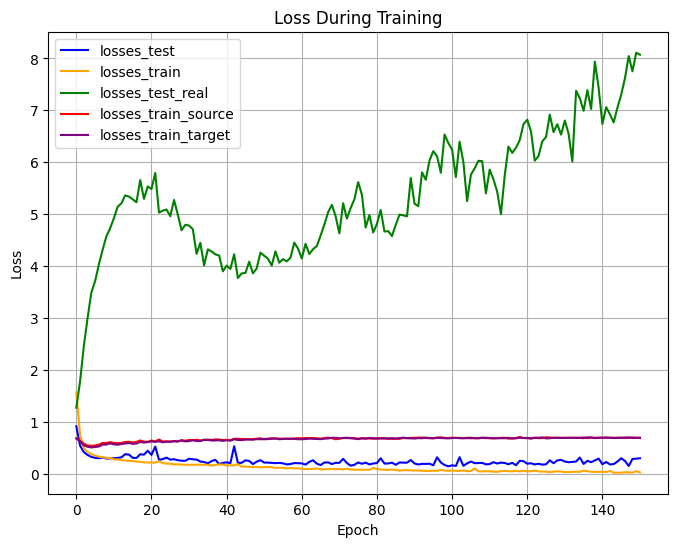

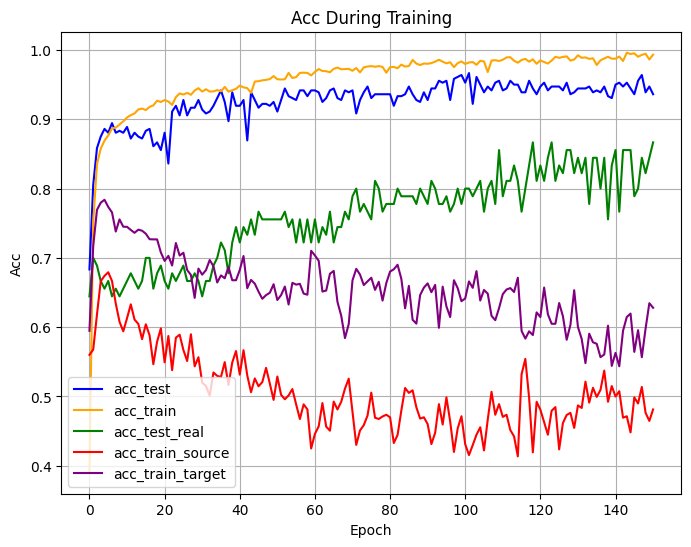

Epoch [151/250], lr: 0.001, alpha: 0.9951, Train Accuracy: 99.33%, Simu_val_Accuracy: 93.61%, REAL_ACCURACY: 86.67%  , Source Accuracy: 48.13%, Target Accuracy: 62.80%, Source Loss: 0.6847, Target Loss: 0.6916, Train_Loss: 0.0230, Simu_val_Loss: 0.2947, Real_Loss: 8.0718
Epoch [152/250], lr: 0.001, alpha: 0.9952, Train Accuracy: 99.05%, Simu_val_Accuracy: 95.28%, REAL_ACCURACY: 83.33%  , Source Accuracy: 42.86%, Target Accuracy: 65.47%, Source Loss: 0.6974, Target Loss: 0.6846, Train_Loss: 0.0285, Simu_val_Loss: 0.1859, Real_Loss: 8.2476
Epoch [153/250], lr: 0.001, alpha: 0.9954, Train Accuracy: 98.71%, Simu_val_Accuracy: 93.89%, REAL_ACCURACY: 80.00%  , Source Accuracy: 45.10%, Target Accuracy: 64.96%, Source Loss: 0.6912, Target Loss: 0.6863, Train_Loss: 0.0390, Simu_val_Loss: 0.2143, Real_Loss: 7.8482
Epoch [154/250], lr: 0.001, alpha: 0.9956, Train Accuracy: 99.36%, Simu_val_Accuracy: 93.06%, REAL_ACCURACY: 80.00%  , Source Accuracy: 47.24%, Target Accuracy: 62.58%, Source Loss: 0.

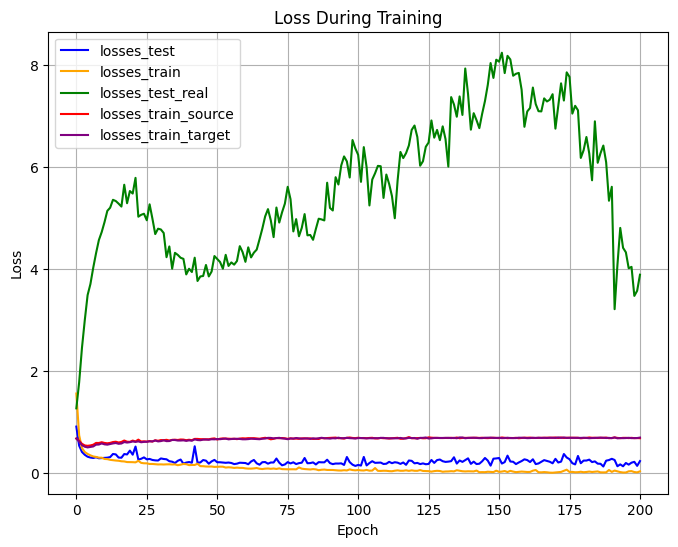

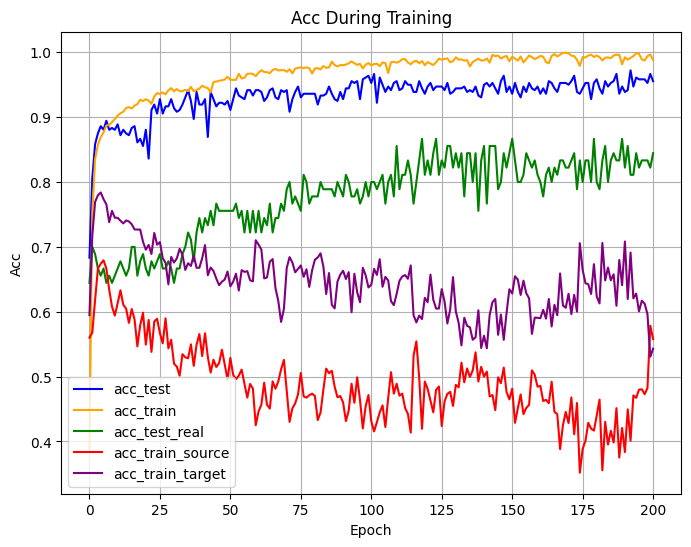

Epoch [201/250], lr: 0.001, alpha: 0.9993, Train Accuracy: 98.84%, Simu_val_Accuracy: 95.56%, REAL_ACCURACY: 84.44%  , Source Accuracy: 55.79%, Target Accuracy: 54.29%, Source Loss: 0.6833, Target Loss: 0.6953, Train_Loss: 0.0329, Simu_val_Loss: 0.2339, Real_Loss: 3.8916
Epoch [202/250], lr: 0.001, alpha: 0.9994, Train Accuracy: 98.93%, Simu_val_Accuracy: 95.28%, REAL_ACCURACY: 82.22%  , Source Accuracy: 55.12%, Target Accuracy: 55.94%, Source Loss: 0.6788, Target Loss: 0.6932, Train_Loss: 0.0360, Simu_val_Loss: 0.2367, Real_Loss: 4.3768
Epoch [203/250], lr: 0.001, alpha: 0.9994, Train Accuracy: 99.30%, Simu_val_Accuracy: 97.22%, REAL_ACCURACY: 83.33%  , Source Accuracy: 34.13%, Target Accuracy: 73.51%, Source Loss: 0.7053, Target Loss: 0.6660, Train_Loss: 0.0226, Simu_val_Loss: 0.1280, Real_Loss: 4.7823
Epoch [204/250], lr: 0.001, alpha: 0.9994, Train Accuracy: 99.54%, Simu_val_Accuracy: 94.72%, REAL_ACCURACY: 74.44%  , Source Accuracy: 48.44%, Target Accuracy: 56.59%, Source Loss: 0.

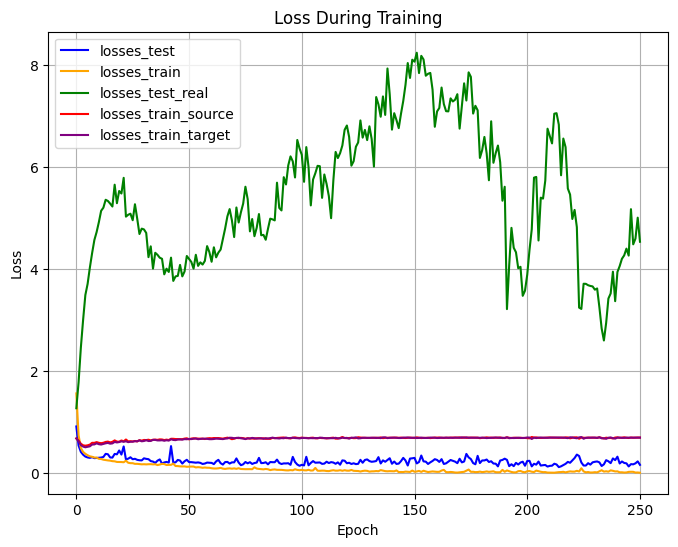

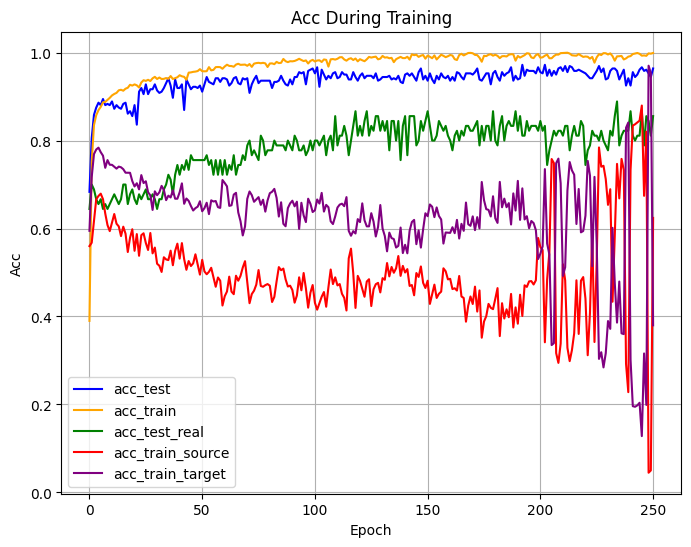

Epoch [251/250], lr: 0.001, alpha: 0.9999, Train Accuracy: 99.91%, Simu_val_Accuracy: 96.39%, REAL_ACCURACY: 85.56%  , Source Accuracy: 62.41%, Target Accuracy: 38.00%, Source Loss: 0.6928, Target Loss: 0.6922, Train_Loss: 0.0033, Simu_val_Loss: 0.1577, Real_Loss: 4.5375
Overall Test Accuracy: 96.39%


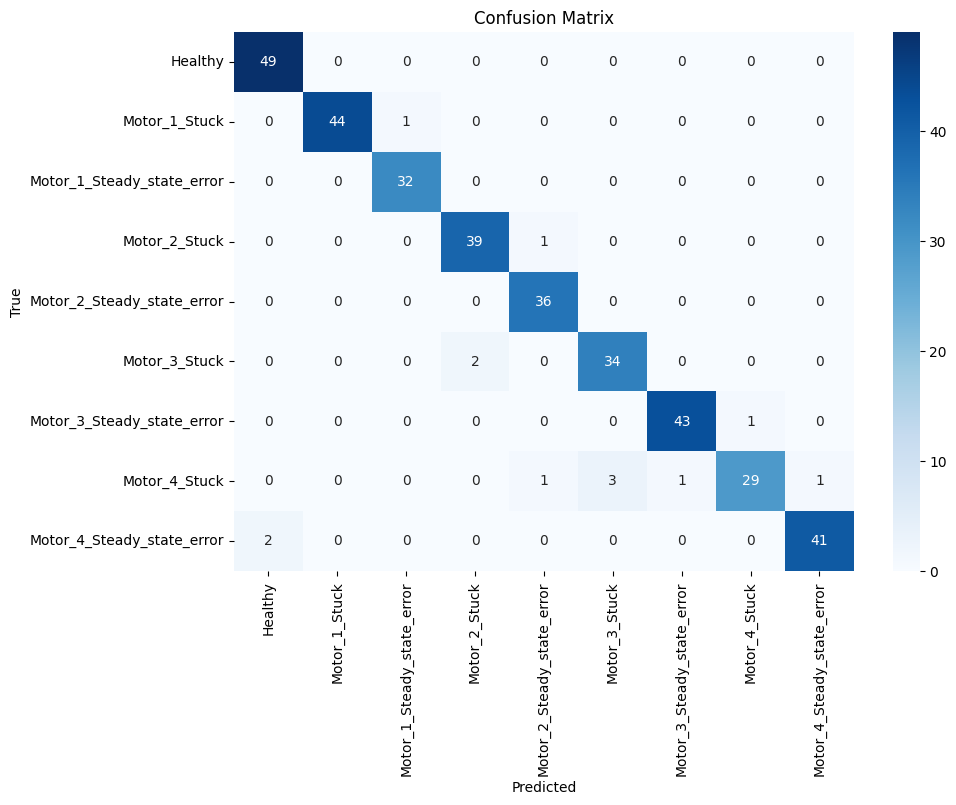

Class 1 (Healthy): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Class 2 (Motor_1_Stuck): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Class 3 (Motor_1_Steady_state_error): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Class 4 (Motor_2_Stuck): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Class 5 (Motor_2_Steady_state_error): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Class 6 (Motor_3_Stuck): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Class 7 (Motor_3_Steady_state_error): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Class 8 (Motor_4_Stuck): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Class 9 (Motor_4_Steady_state_error): Precision = 0.96, Recall = 0.96, F1 Score = 0.96
Overall Test Accuracy: 96.39%


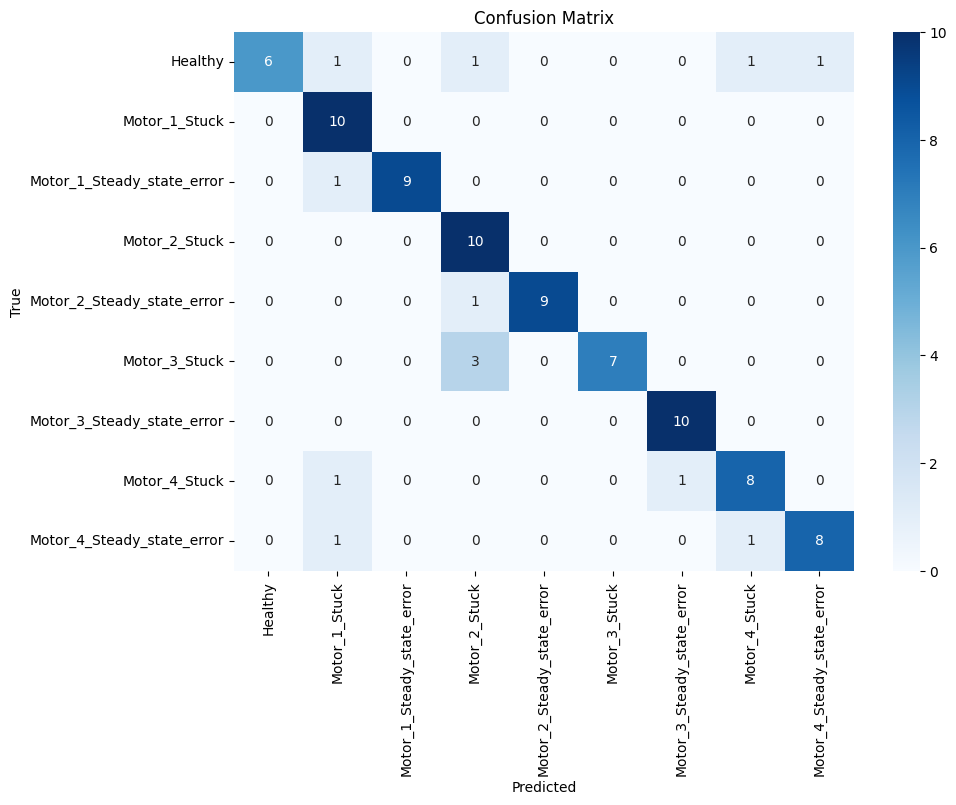

Class 1 (Healthy): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Class 2 (Motor_1_Stuck): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Class 3 (Motor_1_Steady_state_error): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Class 4 (Motor_2_Stuck): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Class 5 (Motor_2_Steady_state_error): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Class 6 (Motor_3_Stuck): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Class 7 (Motor_3_Steady_state_error): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Class 8 (Motor_4_Stuck): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Class 9 (Motor_4_Steady_state_error): Precision = 0.89, Recall = 0.86, F1 Score = 0.86
Test Real Accuracy: 85.56%


In [4]:
# 训练设置
# 不同的损失函数测试中，使用 CrossEntropyLoss/not use softmax 会导致测试集loss上升，使用softmax则正常
# criterion = nn.CrossEntropyLoss()

def criterion(logits, labels):
    # 使用 log_softmax 计算对数概率
    # logits = F.softmax(logits, dim=1)  #模拟在网络结构中最后一层添加一次softmax, 如果在logsoftmax前/后添加一次softmax，或者单独使用softmax就会正常，否则测试集loss就会上升
    log_probs = F.log_softmax(logits, dim=1)
    # log_probs = F.softmax(logits, dim=1)
    # log_probs = F.softmax(log_probs, dim=1)


    # 使用 NLLLoss 计算负对数似然损失
    loss_fn = nn.NLLLoss()
    loss = loss_fn(log_probs, labels)
    
    return loss

# def criterion(logits, labels):
#     labels = labels.to("cpu")
#     logits = logits.to("cpu")
#     # 使用 sigmoid 计算概率
#     probs = torch.sigmoid(logits)
    
#     # 使用 Binary Cross Entropy 计算损失
#     loss_fn = nn.BCELoss()  # 适用于多标签分类
#     one_hot_labels = torch.eye(num_classes)[labels]
#     loss = loss_fn(probs, one_hot_labels)
    
#     return loss

# parameters
mini_batch_size = 32
num_epochs = 250
learning_rate = 0.001
factor=0.1
patience=100
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)

# 训练模型
for epoch in range(num_epochs+1):
    # Compute alpha for Gradient Reversal Layer
    p = float(epoch) / num_epochs
    if p > 1.:
        p = 1.
    alpha = 2. / (1. + np.exp(-10 * p)) - 1

    temp_loss = 0
    temp_loss_source_domain = 0
    temp_loss_target_domain = 0
    temp_acc = 0
    temp_acc_source_domain = 0
    temp_acc_target_domain = 0
    temp_loss_all = []
    temp_loss_source_domain_all = []
    temp_loss_target_domain_all = []
    temp_acc_all = []
    temp_acc_source_domain_all = []
    temp_acc_target_domain_all = []
    model.train()  # 设置模型为训练模式
    for i in range(0, len(X_train), mini_batch_size):
        inputs = X_train[i:i + mini_batch_size].view(-1, 1000, input_size)  # 模型输入格式
        labels = y_train[i:i + mini_batch_size]
        inputs_real = X_test_real.view(-1, 1000, input_size)  # 模型输入格式

        source_domain_label = torch.zeros(len(inputs)).long().to(device)
        target_domain_label = torch.ones(len(inputs_real)).long().to(device)

        # 前向传播
        outputs, source_domain_outputs = model(inputs, alpha) 

        # classify loss source domain
        _, predicted_train = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # domain loss source domain
        # print("shape sdo and sdl:", source_domain_outputs.shape, source_domain_label.shape)
        loss_source_domain = criterion(source_domain_outputs, source_domain_label)

        # forward pass for target domain
        _, target_domain_outputs = model(inputs_real, alpha)
        loss_target_domain = criterion(target_domain_outputs, target_domain_label)

        with torch.no_grad():
            temp_loss_all.append(loss.item())
            temp_loss_source_domain_all.append(loss_source_domain.item())
            temp_loss_target_domain_all.append(loss_target_domain.item())
            temp_acc_all.append(accuracy_score(labels.cpu(), predicted_train.cpu()))
            temp_acc_source_domain_all.append(accuracy_score(source_domain_label.cpu(), torch.argmax(source_domain_outputs, dim=1).cpu()))
            temp_acc_target_domain_all.append(accuracy_score(target_domain_label.cpu(), torch.argmax(target_domain_outputs, dim=1).cpu()))

        # 反向传播和优化
        loss_all = loss + loss_source_domain + loss_target_domain
        optimizer.zero_grad()
        loss_all.backward()
        optimizer.step()

    # 每轮打印测试准确率
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        temp_loss = np.mean(temp_loss_all)
        temp_loss_source_domain = np.mean(temp_loss_source_domain_all)
        temp_loss_target_domain = np.mean(temp_loss_target_domain_all)
        temp_acc = np.mean(temp_acc_all)
        temp_acc_source_domain = np.mean(temp_acc_source_domain_all)
        temp_acc_target_domain = np.mean(temp_acc_target_domain_all)


        test_outputs, _ = model(X_test.view(-1, 1000, input_size))  # 模型输入格式
        _, predicted = torch.max(test_outputs.data, 1)
        loss = criterion(test_outputs, y_test)
        accuracy = accuracy_score(y_test.cpu(), predicted.cpu())

        test_outputs_real, _ = model(X_test_real.view(-1, 1000, input_size))
        _, predicted_real = torch.max(test_outputs_real.data, 1)
        loss_real = criterion(test_outputs_real, y_test_real)
        accuracy_real = accuracy_score(y_test_real.cpu(), predicted_real.cpu())
        
        scheduler.step(loss.item())

        # 记录 loss acc
        losses_train.append(temp_loss)
        losses_test.append(loss.item())
        losses_test_real.append(loss_real.item())
        losses_train_source.append(temp_loss_source_domain)
        losses_train_target.append(temp_loss_target_domain)
        acc_train.append(temp_acc)
        acc_test.append(accuracy)
        acc_test_real.append(accuracy_real)
        acc_train_source.append(temp_acc_source_domain)
        acc_train_target.append(temp_acc_target_domain)


        # 打印和更新图表
        # clear_output(wait=True)
        if epoch%50==0 and epoch!=0:
            plt.figure(figsize=(8,6))
            plt.plot(losses_test, label="losses_test", color='blue')
            plt.plot(losses_train, label="losses_train", color='orange')
            plt.plot(losses_test_real, label="losses_test_real", color='green')
            plt.plot(losses_train_source, label="losses_train_source", color='red')
            plt.plot(losses_train_target, label="losses_train_target", color='purple')
            plt.title('Loss During Training')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(8,6))
            plt.plot(acc_test, label="acc_test", color='blue')
            plt.plot(acc_train, label="acc_train", color='orange')
            plt.plot(acc_test_real, label="acc_test_real", color='green')
            plt.plot(acc_train_source, label="acc_train_source", color='red')
            plt.plot(acc_train_target, label="acc_train_target", color='purple')
            plt.title('Acc During Training')
            plt.xlabel('Epoch')
            plt.ylabel('Acc')
            plt.legend()
            plt.grid(True)
            plt.show()



        current_lr = optimizer.param_groups[0]['lr']

        print(f'Epoch [{epoch + 1}/{num_epochs}], lr: {current_lr}, '
            f'alpha: {alpha:.4f}, '
            f'Train Accuracy: {temp_acc * 100:.2f}%, Simu_val_Accuracy: {accuracy * 100:.2f}%, REAL_ACCURACY: {accuracy_real * 100:.2f}%  , '
            f'Source Accuracy: {temp_acc_source_domain * 100:.2f}%, Target Accuracy: {temp_acc_target_domain * 100:.2f}%, '
            f'Source Loss: {temp_loss_source_domain:.4f}, Target Loss: {temp_loss_target_domain:.4f}, '
            f'Train_Loss: {temp_loss:.4f}, Simu_val_Loss: {loss.item():.4f}, Real_Loss: {loss_real.item():.4f}')



# confusion matrix for simulation validation and real test set
print_confusion_matrix(y_test, predicted, categories)
print_confusion_matrix(y_test_real, predicted_real, categories)

model.eval()  # 设置模型为评估模式
with torch.no_grad():
    test_outputs, _ = model(X_test_real.view(-1, 1000, input_size))  # 模型输入格式
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test_real.cpu(), predicted.cpu())
    print(f'Test Real Accuracy: {accuracy * 100:.2f}%')
